# Xgboost All Features

No standardisation

Pre-requisite: nommesen_april-week2-prepare_data.ipynb

In [30]:
import pandas as pd
import numpy as np
import math

# SKLearn
from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

import xgboost as xgb

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

import matplotlib.pyplot as plt
import seaborn as sns

import joblib


## Loading the training data set

In [2]:
alltrain = np.load('../data/processed/alltrain.npy')

print("Dimension of training data - unsplit", alltrain.shape)

df_alltrain = pd.DataFrame(alltrain, 
             columns=['ID',
                 'Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers',
     'TARGET_5Yrs'
                     ])

df_alltrain['TARGET_5Yrs'] = df_alltrain['TARGET_5Yrs'].astype(dtype ='int64')
df_alltrain['ID'] = df_alltrain['ID'].astype(dtype ='str')

df_alltrain.head()

Dimension of training data - unsplit (8000, 21)


,ID,Games Played,Minutes Played,Points Per Game,Field Goals Made,Field Goals Attempts,Field Goals Percent,3Points Made,3Points Attempts,3Points Percent,...,Free Throw Attempts,Free Throw Percent,Offensive Rebounds,Defensive Rebounds,Rebounds,Assists,Steals,Blocks,Turnovers,TARGET_5Yrs
0,3799.0,80.0,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,3800.0,75.0,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,3801.0,85.0,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,3802.0,63.0,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,3803.0,63.0,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [3]:
df_alltrain['TARGET_5Yrs'].value_counts()

1    6669
0    1331
Name: TARGET_5Yrs, dtype: int64

## Feature selection
All features are used

In [4]:
target = df_alltrain.pop('TARGET_5Yrs')
features = df_alltrain[['Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers']]

# target.info()
# features.info()

## Splitting data
Split randomly the dataset with random_state=8 into 2 different sets: training data (80%) and validation data (20%)

In [5]:
X_train, X_val, y_train, y_val = train_test_split (features, 
                                                   target,
                                                   test_size=0.2,
                                                   random_state=8
                                                  )

print("Dimension of features training data", X_train.shape)
print("Dimension of target training data", y_train.shape)
print("Dimension of features validation data", X_val.shape)
print("Dimension of targer validation data", y_val.shape)

Dimension of features training data (6400, 19)
Dimension of target training data (6400,)
Dimension of features validation data (1600, 19)
Dimension of targer validation data (1600,)


In [6]:
X_train

,Games Played,Minutes Played,Points Per Game,Field Goals Made,Field Goals Attempts,Field Goals Percent,3Points Made,3Points Attempts,3Points Percent,Free Throw Made,Free Throw Attempts,Free Throw Percent,Offensive Rebounds,Defensive Rebounds,Rebounds,Assists,Steals,Blocks,Turnovers
3617,64.0,13.9,4.3,1.5,3.6,43.0,-0.2,-0.1,11.9,1.4,1.9,69.2,0.6,1.7,2.2,0.6,0.4,0.1,0.7
1120,81.0,20.8,7.6,2.7,6.2,44.8,0.4,1.1,12.1,1.8,2.1,79.0,1.7,4.0,5.6,0.7,0.6,0.1,1.3
3873,50.0,5.6,1.4,0.5,1.5,36.4,0.0,0.5,-3.1,0.2,0.2,68.6,0.1,0.2,0.4,1.5,0.4,-0.3,0.3
153,72.0,19.3,5.0,2.0,5.0,40.4,0.1,0.5,25.3,0.9,1.6,48.4,0.7,2.0,2.9,1.1,0.5,0.2,0.9
2960,45.0,19.7,6.1,2.5,5.9,42.1,0.1,0.4,-2.7,1.1,1.7,62.0,1.0,1.5,2.6,1.5,0.4,0.3,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181,74.0,46.4,18.7,7.4,16.3,45.3,0.8,2.3,42.2,3.1,4.5,68.0,1.9,6.2,8.4,3.4,1.4,0.3,3.0
2409,59.0,14.8,3.4,1.0,3.2,33.7,0.5,1.7,14.3,1.3,2.0,56.3,0.7,1.2,2.1,1.5,0.9,0.1,0.7
2033,55.0,15.6,3.3,1.1,2.4,44.4,0.6,1.8,32.0,0.7,1.0,72.7,1.1,2.3,3.3,1.0,0.5,0.3,0.8
1364,91.0,47.9,12.1,4.2,9.6,46.0,0.4,1.3,-0.6,3.2,4.6,66.4,3.0,6.5,9.8,4.2,0.9,0.6,1.6


## Model Development

XGBoost

### XGBoost Default Parameters (XGBOOST0)

In [7]:
# instantiate the model (default parameters)
xgboost0_train = xgb.XGBClassifier()

# fit the model with data
xgboost0_train.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [8]:
# save the model to disk
my_model_filename = '../models/xgboost0.sav'
joblib.dump(xgboost0_train, my_model_filename)

['../models/xgboost0.sav']

### XGBoost with hyperparameter tuning using Hyperopt (XGBOOST1)

In [9]:
# Define the search space for xgboost hyperparameters
# space = {
#     'max_depth' : hp.choice('max_depth', range(5, 20, 1)),
#     'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
#     'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
#     'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
#     'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05)
# }


space={'max_depth': hp.quniform('max_depth', 3, 18, 1),
       'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
       'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': 180,
       'seed': 0
    }


# Define a function called `objective` with the following logics:
# input parameters: hyperparameter seacrh space (`space`)
# logics: train a xgboost model with the search space and calculate the average accuracy score for cross validation with 10 folds
# output parameters: dictionary with the loss score and STATUS_OK


def objective(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = xgb.XGBClassifier(
        max_depth = int(space['max_depth']),        
        learning_rate = space['learning_rate'],
        subsample = space['subsample'],
        gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],
        reg_lambda = space['reg_lambda'],        
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        n_estimators = space['n_estimators'],
        seed = space['seed'],
        scale_pos_weight = 0.20
    )
    
    acc = cross_val_score(xgboost, X_train, y_train, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }



# Launch Hyperopt search and save the result in a variable called `best`
best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)


# Print the best set of hyperparameters
print("Best: ", best)


100% 5/5 [00:22<00:00,  4.42s/trial, best loss: 0.3184098952830281]
Best:  {'colsample_bytree': 0.7910767078737142, 'gamma': 6.7342436543686945, 'learning_rate': 0.25, 'max_depth': 11.0, 'min_child_weight': 1.0, 'reg_alpha': 43.0, 'reg_lambda': 0.008292931802290737, 'subsample': 0.65}


In [10]:
# instantiate the model (XGBClassifier with best set of hyperparameters)
xgboost1_train = xgb.XGBClassifier(
        max_depth = int(best['max_depth']),        
        learning_rate = best['learning_rate'],    
        subsample = best['subsample'],
        gamma = best['gamma'],
        reg_alpha = best['reg_alpha'],
        reg_lambda = best['reg_lambda'],        
        min_child_weight = best['min_child_weight'],
        colsample_bytree = best['colsample_bytree'],
        n_estimators = 180,
        seed = 0,
        scale_pos_weight = 0.20
    )

# fit the model with data
xgboost1_train.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7910767078737142, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=6.7342436543686945, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=11, max_leaves=0,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, ...)

In [11]:
# save the model to disk
joblib.dump(xgboost1_train, '../models/xgboost1.sav')

['../models/xgboost1.sav']

## Model Evaluation

In [12]:
# Load the model from the file 
xgboost0_from_joblib = joblib.load('../models/xgboost0.sav') 

# Predict on training set
y_pred_ontrain_xgboost0 = xgboost0_from_joblib.predict(X_train)

# Accuracy
print( accuracy_score(y_pred_ontrain_xgboost0, y_train) )

0.97859375


In [13]:
# Load the model from the file 
xgboost1_from_joblib = joblib.load('../models/xgboost1.sav') 

# Predict on training set
y_pred_ontrain_xgboost1 = xgboost1_from_joblib.predict(X_train)

# Accuracy
print( accuracy_score(y_pred_ontrain_xgboost1, y_train) )

0.611875


### Prediction on validation data

In [14]:
y_pred_onval_xgboost0 = xgboost0_from_joblib.predict(X_val)
y_pred_onval_xgboost0

array([1, 1, 1, ..., 1, 1, 1])

In [15]:
y_pred_onval_xgboost1 = xgboost1_from_joblib.predict(X_val)
y_pred_onval_xgboost1

array([0, 0, 1, ..., 1, 0, 1])

### Confusion Matrix

#### XGBOOST 0

In [16]:
cnf_matrix_xgboost0 = metrics.confusion_matrix(y_val, y_pred_onval_xgboost0)
cnf_matrix_xgboost0


array([[  23,  234],
       [  64, 1279]])

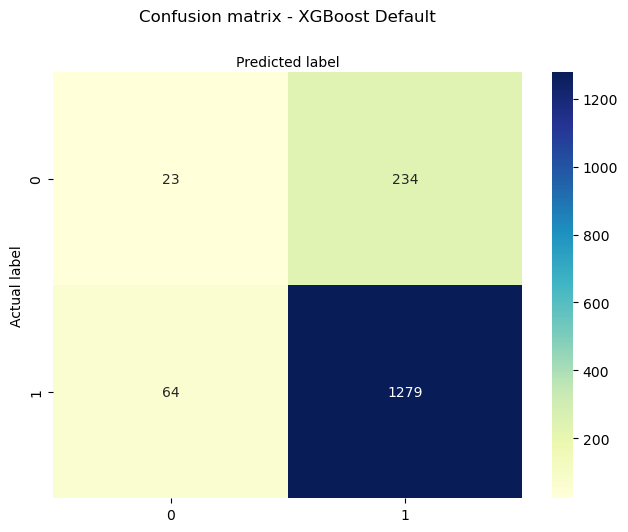

In [17]:
class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_xgboost0), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - XGBoost Default', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

#### XGBOOST 1

In [18]:
cnf_matrix_xgboost1 = metrics.confusion_matrix(y_val, y_pred_onval_xgboost1)
cnf_matrix_xgboost1

array([[177,  80],
       [559, 784]])

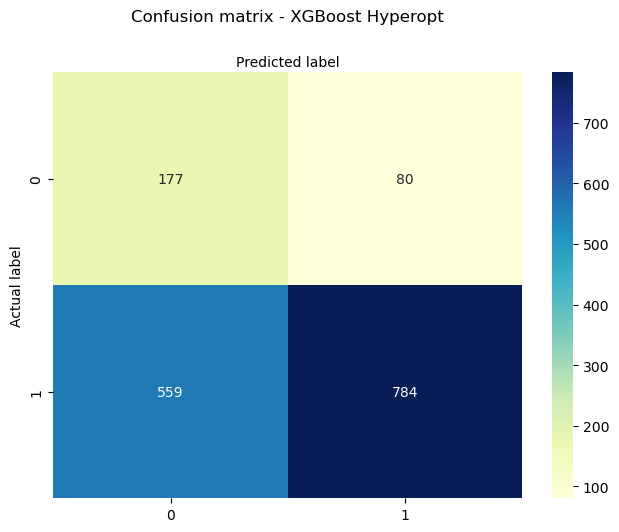

In [19]:
class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_xgboost1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - XGBoost Hyperopt', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

### Accuracy, Precision, and Recall

In [20]:
target_names = ['career years played < 5', 'career years played >= 5']

In [21]:
print("---------- XGBoost Default ----------")
print(classification_report(y_val, y_pred_onval_xgboost0, target_names=target_names))

---------- XGBoost Default ----------
                          precision    recall  f1-score   support

 career years played < 5       0.26      0.09      0.13       257
career years played >= 5       0.85      0.95      0.90      1343

                accuracy                           0.81      1600
               macro avg       0.55      0.52      0.51      1600
            weighted avg       0.75      0.81      0.77      1600



In [23]:
print("---------- XGBoost with Hyperopt ----------")
print(classification_report(y_val, y_pred_onval_xgboost1, target_names=target_names))

---------- XGBoost with Hyperopt ----------
                          precision    recall  f1-score   support

 career years played < 5       0.24      0.69      0.36       257
career years played >= 5       0.91      0.58      0.71      1343

                accuracy                           0.60      1600
               macro avg       0.57      0.64      0.53      1600
            weighted avg       0.80      0.60      0.65      1600



### ROC

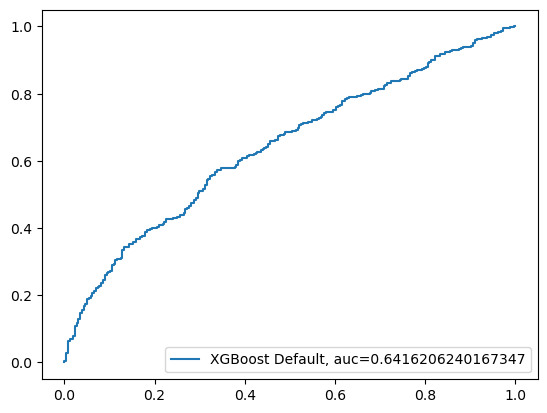

In [24]:

y_proba_onval_xgboost0 = xgboost0_from_joblib.predict_proba(X_val)[::,1]  # official
fpr, tpr, _ = metrics.roc_curve(y_val,  y_proba_onval_xgboost0)
auc_xgboost0 = metrics.roc_auc_score(y_val, y_proba_onval_xgboost0)

plt.plot(fpr,tpr,label="XGBoost Default, auc="+str(auc_xgboost0))
plt.legend(loc=4)
plt.show()

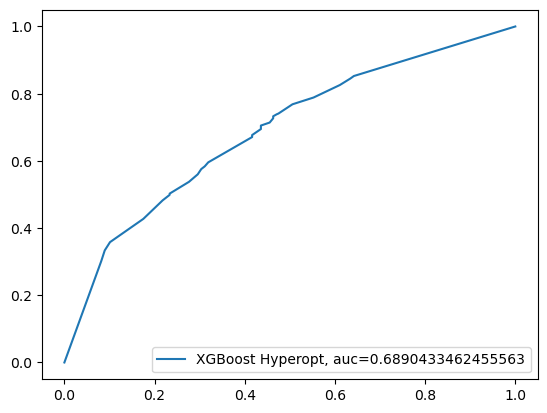

In [25]:

y_proba_onval_xgboost1 = xgboost1_from_joblib.predict_proba(X_val)[::,1]  # official
fpr, tpr, _ = metrics.roc_curve(y_val,  y_proba_onval_xgboost1)
auc_xgboost1 = metrics.roc_auc_score(y_val, y_proba_onval_xgboost1)

plt.plot(fpr,tpr,label="XGBoost Hyperopt, auc="+str(auc_xgboost1))
plt.legend(loc=4)
plt.show()

## XGBoost Feature Importance

In [26]:
mapper = {v:format(X_train.columns[i]) for i, v in enumerate(X_train.columns)}
print(mapper)

{'Games Played': 'Games Played', 'Minutes Played': 'Minutes Played', 'Points Per Game': 'Points Per Game', 'Field Goals Made': 'Field Goals Made', 'Field Goals Attempts': 'Field Goals Attempts', 'Field Goals Percent': 'Field Goals Percent', '3Points Made': '3Points Made', '3Points Attempts': '3Points Attempts', '3Points Percent': '3Points Percent', 'Free Throw Made': 'Free Throw Made', 'Free Throw Attempts': 'Free Throw Attempts', 'Free Throw Percent': 'Free Throw Percent', 'Offensive Rebounds': 'Offensive Rebounds', 'Defensive Rebounds': 'Defensive Rebounds', 'Rebounds': 'Rebounds', 'Assists': 'Assists', 'Steals': 'Steals', 'Blocks': 'Blocks', 'Turnovers': 'Turnovers'}


#### XGBOOST 0

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

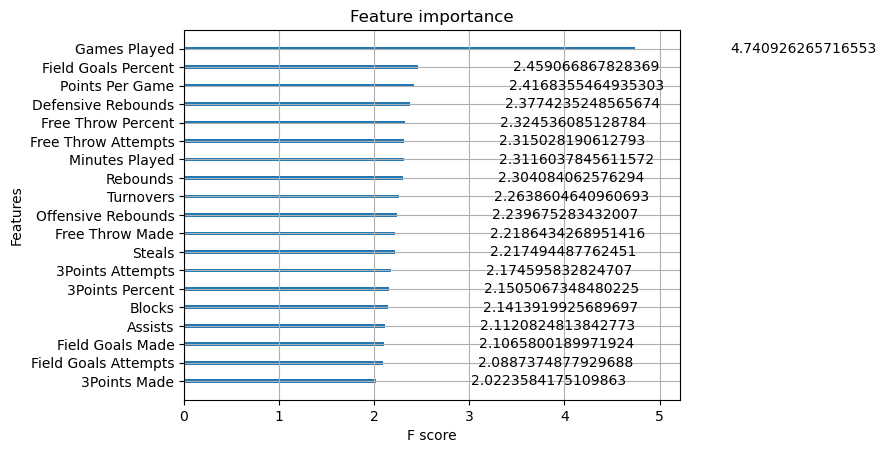

In [28]:
feat_imp0 = xgboost0_from_joblib.get_booster().get_score(importance_type="gain")
mapping0 = {mapper[k]: v for k, v in feat_imp0.items()}
xgb.plot_importance(mapping0, max_num_features=20)

In [31]:
#Calculate variable importance by permutation on the training set
r = permutation_importance(
    xgboost0_from_joblib, X_train, y_train,
    n_repeats=30,
    random_state=8
)

#Sort the variable importance, iterate through the features and print their values
for i in r.importances_mean.argsort()[::-1]:
     print(f"{X_train.columns[i]}: {r.importances_mean[i]:.5f}")

Games Played: 0.07206
3Points Percent: 0.05087
Free Throw Percent: 0.04869
Field Goals Percent: 0.04306
Offensive Rebounds: 0.04263
Assists: 0.03910
Minutes Played: 0.03482
3Points Attempts: 0.02782
Turnovers: 0.02726
Field Goals Attempts: 0.02632
3Points Made: 0.02581
Defensive Rebounds: 0.02218
Blocks: 0.02139
Points Per Game: 0.02047
Steals: 0.02034
Free Throw Attempts: 0.01927
Rebounds: 0.01874
Free Throw Made: 0.01728
Field Goals Made: 0.01651


#### XGBOOST 1

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

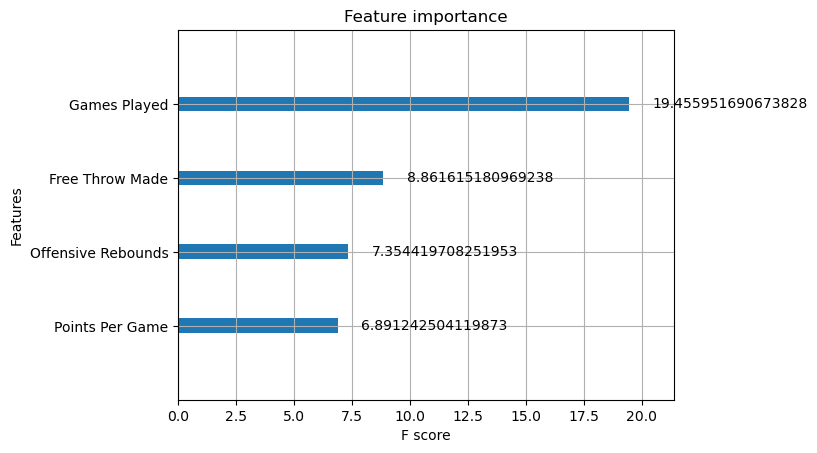

In [29]:
feat_imp1 = xgboost1_from_joblib.get_booster().get_score(importance_type="gain")
mapping1 = {mapper[k]: v for k, v in feat_imp1.items()}
xgb.plot_importance(mapping1, max_num_features=20)

In [32]:
#Calculate variable importance by permutation on the training set
r = permutation_importance(
    xgboost1_from_joblib, X_train, y_train,
    n_repeats=30,
    random_state=8
)

#Sort the variable importance, iterate through the features and print their values
for i in r.importances_mean.argsort()[::-1]:
     print(f"{X_train.columns[i]}: {r.importances_mean[i]:.5f}")

Games Played: 0.06797
Blocks: 0.00000
Minutes Played: 0.00000
Field Goals Made: 0.00000
Field Goals Attempts: 0.00000
Field Goals Percent: 0.00000
3Points Made: 0.00000
3Points Attempts: 0.00000
3Points Percent: 0.00000
Turnovers: 0.00000
Free Throw Attempts: 0.00000
Free Throw Percent: 0.00000
Defensive Rebounds: 0.00000
Rebounds: 0.00000
Assists: 0.00000
Steals: 0.00000
Offensive Rebounds: -0.01036
Free Throw Made: -0.01850
Points Per Game: -0.01879


## Test on unseen data

### Loading the test data set

In [ ]:
test = np.load('../data/processed/test.npy')

print("Dimension of training data - unsplit", test.shape)

df_test = pd.DataFrame(test, 
             columns=['ID',
                 'Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers'
                     ])

df_test['ID'] = df_test['ID'].astype(int)
df_test['ID'] = df_test['ID'].astype(str)

# df_test_indexed=df_test.set_index('ID')

df_test.head()

In [ ]:
df_test.info()

In [ ]:
df_features_test = df_test[['Games Played', 
    'Minutes Played',
    'Points Per Game',
    'Field Goals Made',
    'Field Goals Attempts',
    'Field Goals Percent',
    '3Points Made',
    '3Points Attempts',
    '3Points Percent',
    'Free Throw Made',
    'Free Throw Attempts',
    'Free Throw Percent',
    'Offensive Rebounds',
    'Defensive Rebounds',
    'Rebounds',
    'Assists',
    'Steals',
    'Blocks',
    'Turnovers']]

df_features_test.head()

### Predictions

In [ ]:
# Use the loaded model to make predictions 
y_pred_ontest = xgboost0_from_joblib.predict(df_features_test)

df_test_predictions = pd.DataFrame(y_pred_ontest, columns=['TARGET_5Yrs'])

df_test_predictions.TARGET_5Yrs.value_counts()

In [ ]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x = 'TARGET_5Yrs',
              data = df_test_predictions,
              palette = 'hls'
             )
plt.show()
plt.savefig('count_plot')

### Submit Prediction to Kaggle

In [ ]:
# Use the loaded model to make predictions 
y_test = xgboost0_from_joblib.predict_proba(df_features_test)

In [ ]:
y_test

In [ ]:
df_test_probabilites = pd.DataFrame(y_test, 
             columns=['TARGET_5Yrs_0',
                 'TARGET_5Yrs'
                     ])

In [ ]:
df_test_probabilites.head()

In [ ]:
output = df_test.join(df_test_probabilites)
output=output.set_index('ID')

output

In [ ]:
output['TARGET_5Yrs'].to_csv('../models/nommesen_april_week4_model-xgboost0.csv')